In [18]:
import sys
# sys.path.append("C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages")
import os
import numpy as np
import pandas as pd
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
sys.path = ["C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages"] + sys.path

from config import *
from utils.util import *
from model import *
from iterator import DataGenerator

sys
os


In [19]:
opts = TrainOption('cls')

In [20]:
hist = pd.read_csv(os.path.join(RESULT_PATH,"checkpoint_hist.csv"))

In [21]:
hist.tail()

,epoch,loss,auc,val_loss,val_auc
19,19,1.635980,0.998412,0.232449,0.954583
20,20,1.593924,0.998645,0.250729,0.943819
21,21,1.570635,0.998735,0.359700,0.949861
22,22,1.530076,0.998809,0.227561,0.937847
23,23,1.500978,0.998897,0.217064,0.957708


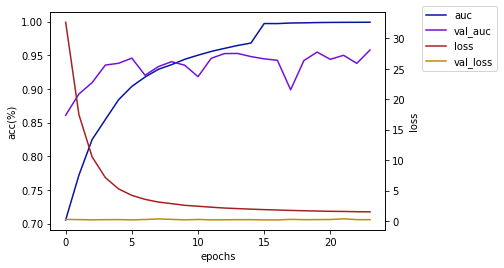

In [22]:
history_graph(hist,metics='auc')

In [23]:
test_iterator = DataGenerator(TEST_IMAGE, MASK_LOC ,opts.BATCH_SIZE 
                               ,IMAGE_SHAPE, OPTIC_DISC_SHAPE, is_train=False, copy = False, sample=None)

 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400 Done


In [24]:
import json
with open(os.path.join(RESULT_PATH,"model.json"), 'r') as f:
    model_json = json.loads(f.read())

In [25]:
model = keras.models.model_from_json(model_json)

## Best epoch : checkpoint-024.h5

In [27]:
model.load_weights(os.path.join(RESULT_PATH,"checkpoint-024.h5"))

In [28]:
y_pred = model.predict_generator(test_iterator,
                                 steps=None,
                                 max_queue_size=10,
                                 workers=2,
                                 use_multiprocessing=False,
                                 verbose=1
                                 )

200/200 [==============================] - 254s 1s/step


In [68]:
y_true = test_iterator.get_label()

In [73]:
print_confusion_matrix(y_true, y_pred,0.2)

0.2      1,      0
      1     30,     13
      0     10,    347


In [74]:
error_df = pd.DataFrame({"Class":y_true.flatten(), "y_pred":y_pred.flatten()})

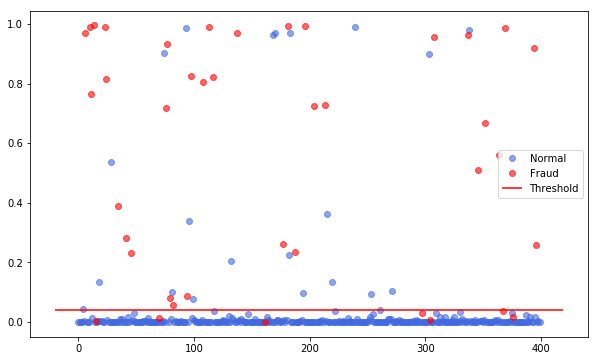

In [75]:
visualize_anomaly(error_df,threshold=0.04)